In [1]:
import pandas as pd
from pyxlsb import open_workbook
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
def grafico_dispersion_2_var(df, var1, var2):
    sns.scatterplot(data=df, x=var1, y=var2, hue='default')
    plt.show()

In [3]:
# Define la ruta al archivo .xlsb
file_path = './BBDD_Scoring.xlsb' 

# Inicializa una lista para almacenar los datos
data = []

# Lee el archivo y extrae las filas
with open_workbook(file_path) as wb:
    with wb.get_sheet(1) as sheet:  # Cambia "1" al índice correcto de la hoja si es necesario
        for row in sheet.rows():
            # Extrae los valores de cada fila
            data.append([item.v for item in row])

# Convierte los datos en un DataFrame
df = pd.DataFrame(data[1:], columns=data[0])  # Usa la primera fila como nombres de columnas

In [4]:
# Calcular número de valores distintos en cada columna
columnas_sin_valores_distintos = df.nunique()[df.nunique() < 2].index
df = df.drop(columnas_sin_valores_distintos, axis=1)

In [5]:
# Convertir a variables categóricas para su posterior análisis
df['Cliente'] = df['Cliente'].astype('object')
df['default'] = df['default'].astype('object')
df['Indicador_tarjeta'] = df['Indicador_tarjeta'].astype('object')
df['Indicador_recibos'] = df['Indicador_recibos'].astype('object')

In [6]:
df['saldo_<_30k'] = (df['Saldo_total'] < 30000).astype(int)

# Tabla con porcentaje de cantidad de personas con saldo menor a 30k y default
tabla = df.groupby('default')['saldo_<_30k'].value_counts(normalize=True).unstack()
display(tabla) # significa que el 97% de las personas con saldo menor a 30k han entrado en default y solo el 

tabla2 = df.groupby('saldo_<_30k')['default'].value_counts(normalize=True).unstack()
display(tabla2)

saldo_<_30k,0,1
default,,
0.0,0.189171,0.810829
1.0,0.033505,0.966495


default,0.0,1.0
saldo_<_30k,,
0,0.999724,0.000276
1,0.998146,0.001854


In [7]:
df['Gastos/Ingresos'] = df['Gastos'] / df['Ingresos_totales']
df['Cuotas_ptmos/Ingresos'] = df['Cuotas_ptmos'] / df['Ingresos_totales']
df['Recibos_denegados_dummy'] = (df['Recibos_denegados'] > 0).astype(int)
df['Ant_hipotecaria_>_100'] = (df['Ant_hipotecaria'] > 100).astype(int)

In [8]:
variables_interes = [
    'default', 'Edad', 'Dias_impago_hip_year', 'Dias_mora_hip_year',
    'Dias_impago_descubierto_year', 'Saldo_total',
    'Saldo_cta_corriente_year', 'Ingresos_totales', 'Gastos', 'Mora_ult5A'
]

**Análisis Univariante**

Este análisis examina cada variable individualmente, proporcionando una visión general de la distribución de cada variable. Esto incluye el cálculo de estadísticas descriptivas (como la media, mediana, varianza) y la visualización de su distribución (con histogramas, boxplots, etc.). En el caso de nuestro análisis de calidad crediticia, este paso es fundamental para entender las características de los datos, como valores atípicos, asimetrías y posibles problemas de calidad.

In [9]:
variables_categoricas = df.select_dtypes(include=['object']).columns
variables_categoricas

Index(['Cliente', 'default', 'Indicador_tarjeta', 'Indicador_recibos'], dtype='object')

In [10]:
# Calcular frecuencias de categorías antes de graficar
frecuencias_categoricas = {col: df[col].value_counts() for col in variables_categoricas}

Cliente tiene demasiadas categorías, omitiendo gráfico.


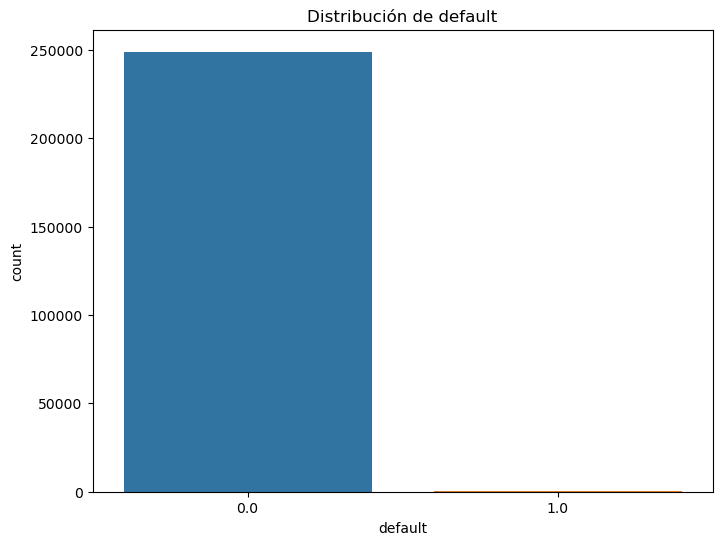

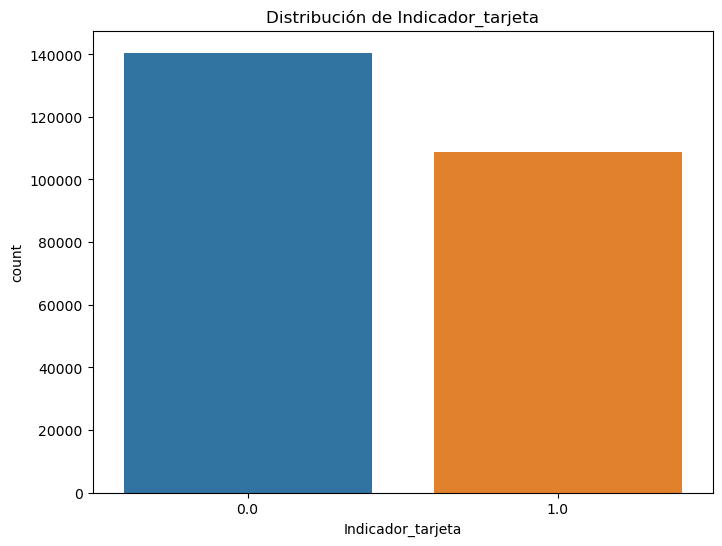

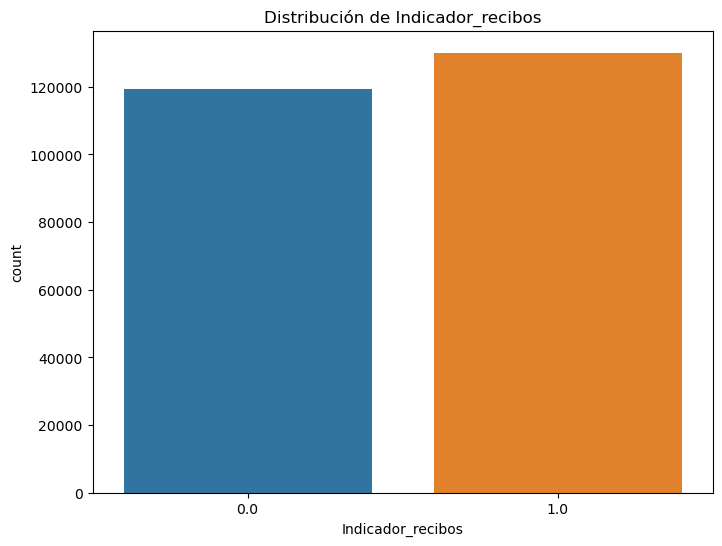

In [11]:
# Distribución de variables categóricas optimizado
for col in variables_categoricas:
    # # Mostrar la frecuencia de categorías
    # print(f'\nFrecuencia de categorías en {col}:')
    # print(frecuencias_categoricas[col])

    # Graficar sólo si hay menos de 10 categorías (esto es un ejemplo, puedes ajustarlo)
    if len(frecuencias_categoricas[col]) <= 10:
        plt.figure(figsize=(8, 6))
        sns.countplot(data=df, x=col)
        plt.title(f'Distribución de {col}')
        plt.show()
    else:
        print(f'{col} tiene demasiadas categorías, omitiendo gráfico.')

In [12]:
variables_continuas = df.select_dtypes(include=['int', 'float']).columns
len(variables_continuas)

54

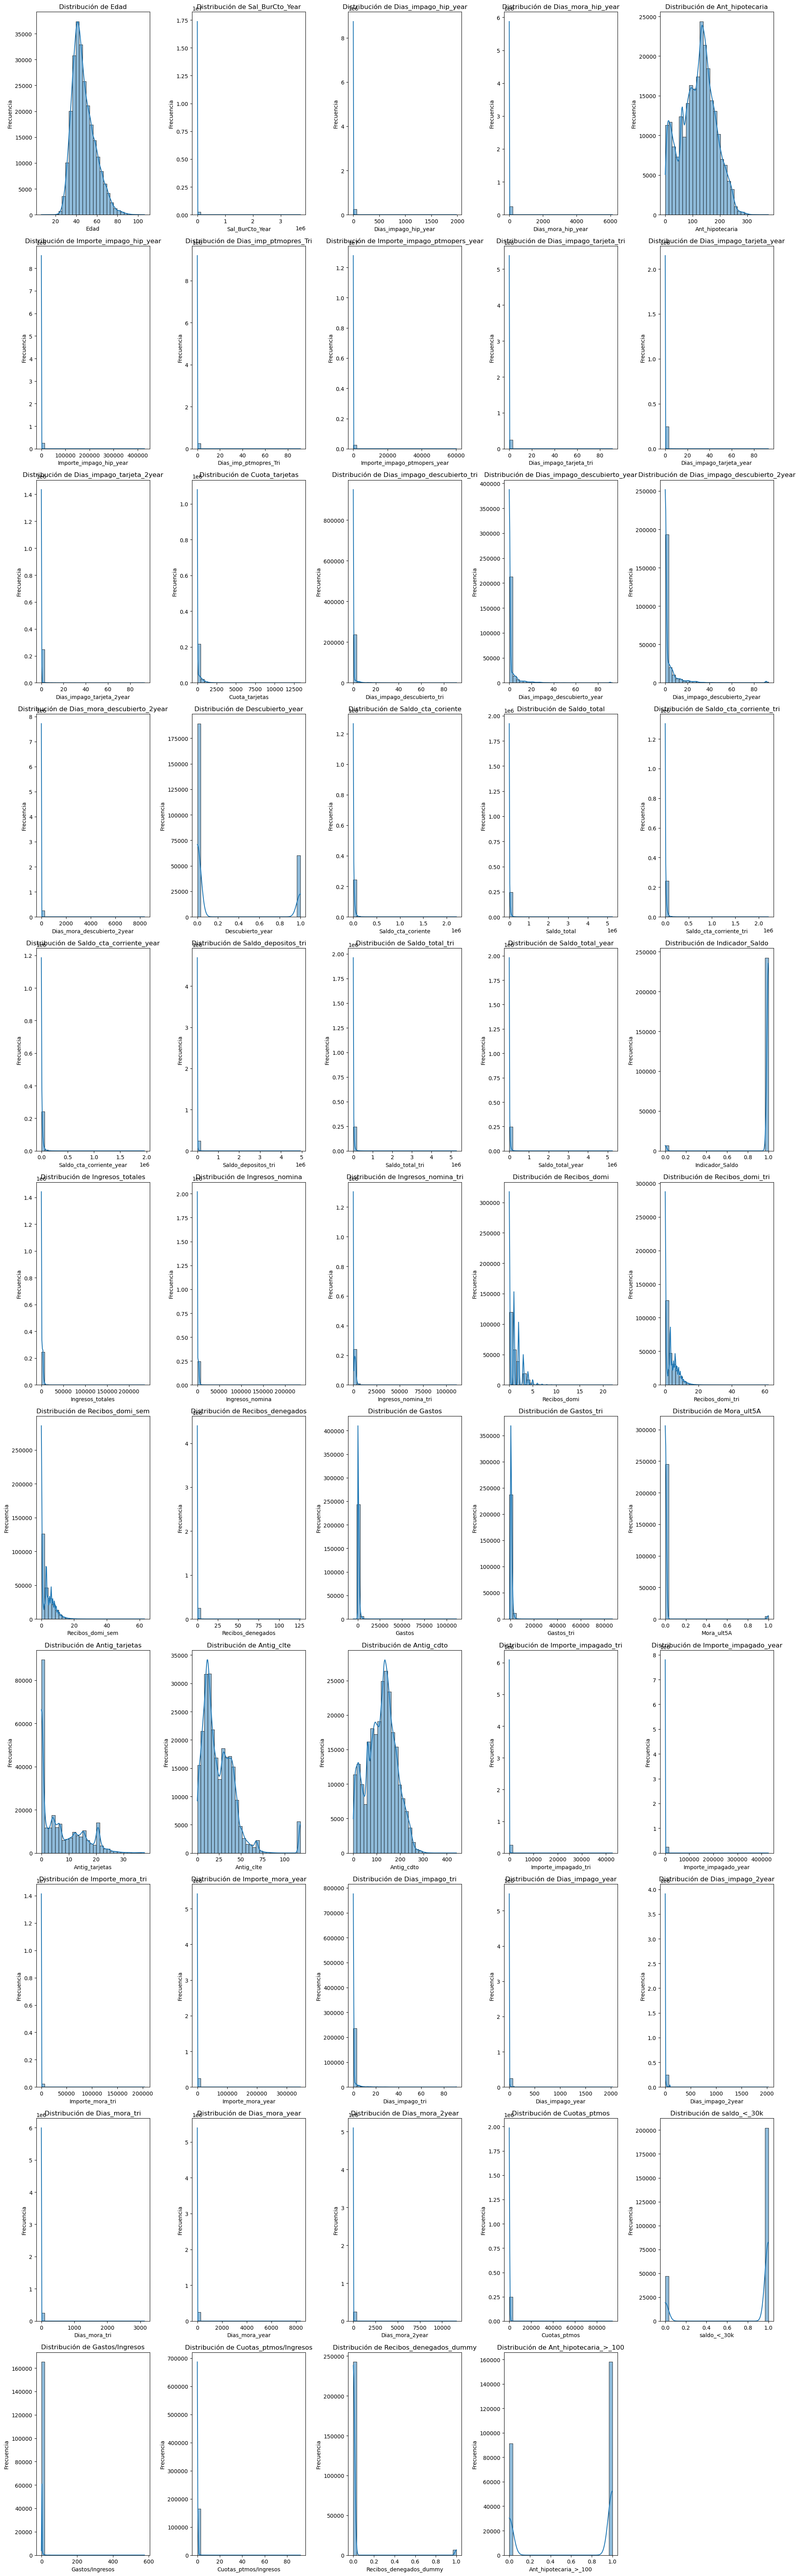

In [13]:
# Estadísticos descriptivos de las variables continuas
variables_continuas = df.select_dtypes(include=['int', 'float']).columns

# Número de filas y columnas para la cuadrícula
n_cols = 5
n_rows = (len(variables_continuas) // n_cols) + (len(variables_continuas) % n_cols > 0)

# Crear la figura y los subgráficos
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 6))

# Aplanar la matriz de ejes para facilitar el acceso
axes = axes.flatten()

# Crear los histogramas
for i, var in enumerate(variables_continuas):
    sns.histplot(df[var], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Distribución de {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frecuencia')

# Eliminar los ejes adicionales si hay menos variables que subgráficos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajustar el layout para evitar solapamientos
plt.tight_layout()
plt.show()

Outliers en Edad: 3607
Outliers en Sal_BurCto_Year: 6512
Outliers en Dias_impago_hip_year: 22830
Outliers en Dias_mora_hip_year: 382
Outliers en Ant_hipotecaria: 199
Outliers en Importe_impago_hip_year: 22715
Outliers en Dias_imp_ptmopres_Tri: 80
Outliers en Importe_impago_ptmopers_year: 596
Outliers en Dias_impago_tarjeta_tri: 617
Outliers en Dias_impago_tarjeta_year: 2698
Outliers en Dias_impago_tarjeta_2year: 4592
Outliers en Cuota_tarjetas: 47303
Outliers en Dias_impago_descubierto_tri: 24021
Outliers en Dias_impago_descubierto_year: 60129
Outliers en Dias_impago_descubierto_2year: 30732
Outliers en Dias_mora_descubierto_2year: 618
Outliers en Descubierto_year: 60129
Outliers en Saldo_cta_coriente: 23387
Outliers en Saldo_total: 24795
Outliers en Saldo_cta_corriente_tri: 23104
Outliers en Saldo_cta_corriente_year: 22635
Outliers en Saldo_depositos_tri: 45285
Outliers en Saldo_total_tri: 24640
Outliers en Saldo_total_year: 24681
Outliers en Indicador_Saldo: 6942
Outliers en Ingresos

c:\Users\Usuario\anaconda3\envs\DM_reto9\lib\site-packages\numpy\core\_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


Outliers en Recibos_denegados_dummy: 6775
Outliers en Ant_hipotecaria_>_100: 0


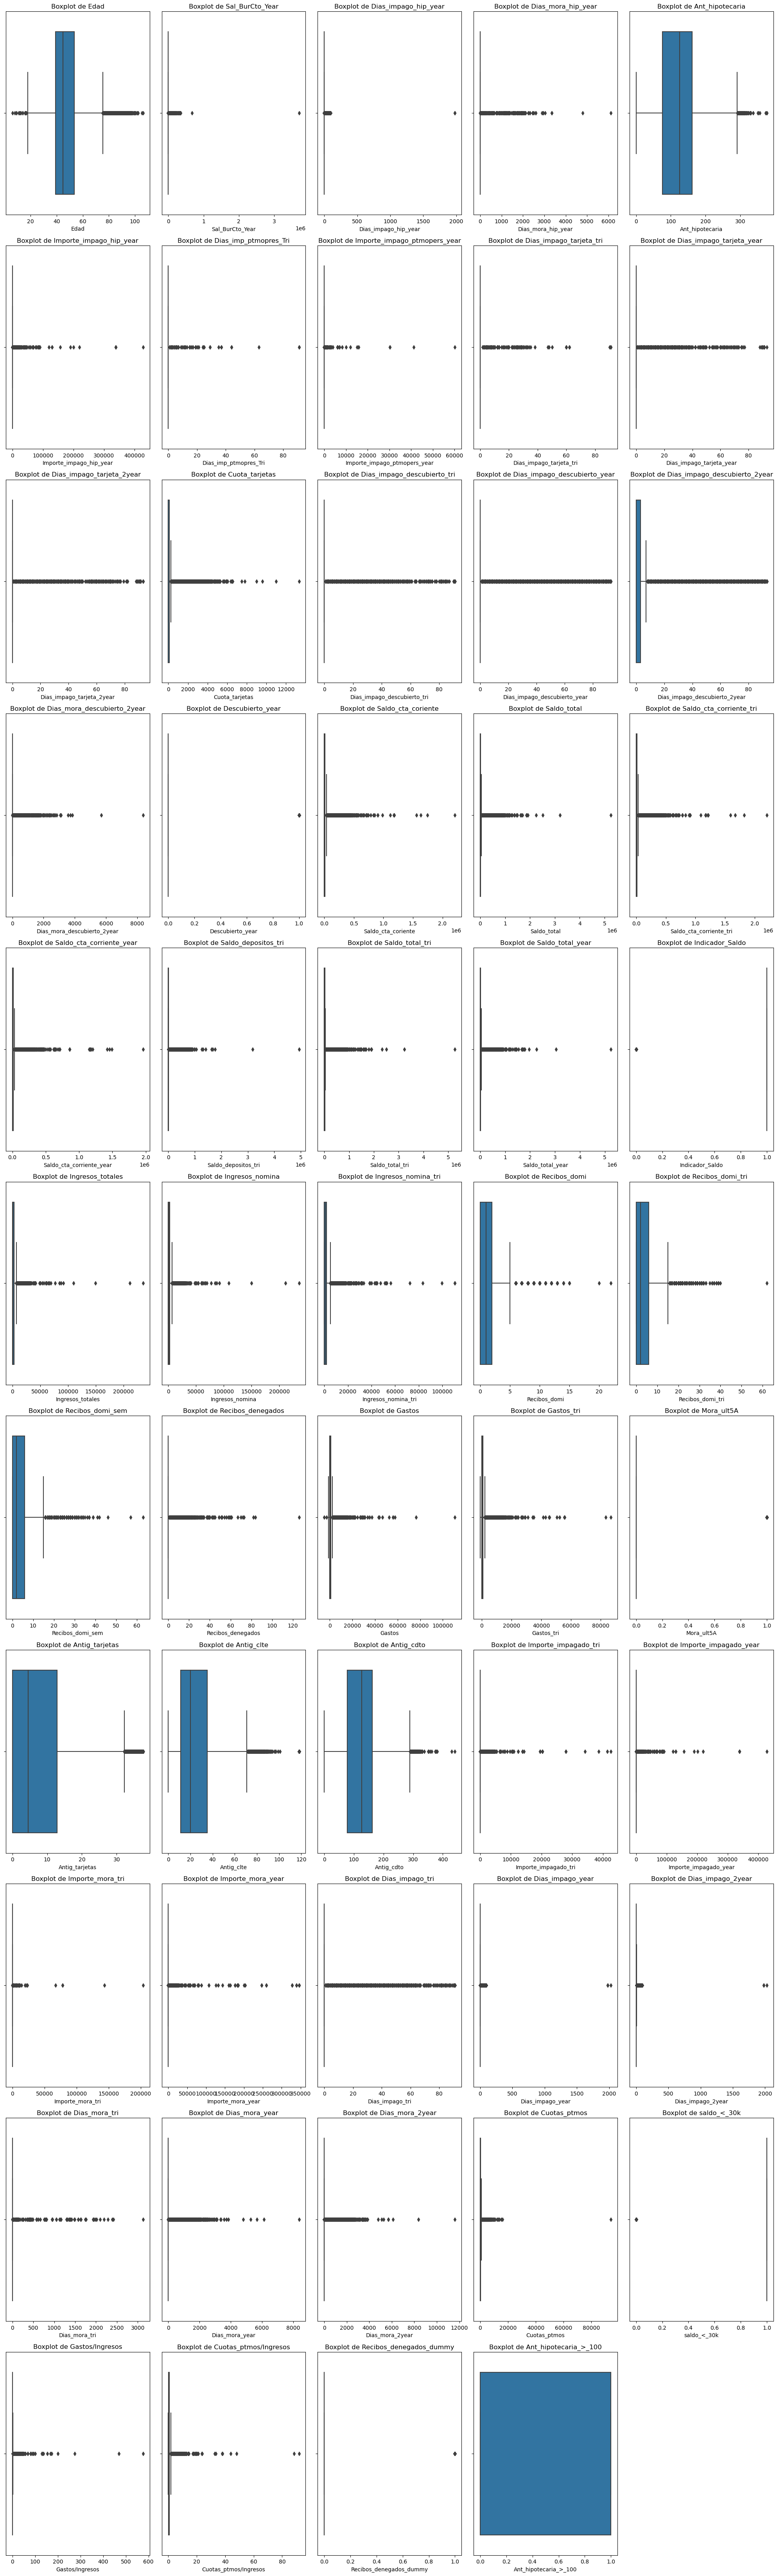

In [14]:
# Detección de outliers mediante IQR
def detectar_outliers(df, variable):
    Q1 = df[variable].quantile(0.25)
    Q3 = df[variable].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    return df[(df[variable] < limite_inferior) | (df[variable] > limite_superior)]

# Número de filas y columnas para la cuadrícula
n_cols = 5
n_rows = (len(variables_continuas) // n_cols) + (len(variables_continuas) % n_cols > 0)

# Crear la figura y los subgráficos
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 6))

# Aplanar la matriz de ejes para facilitar el acceso
axes = axes.flatten()

# Mostrar outliers y boxplots por cada variable continua
for i, var in enumerate(variables_continuas):
    outliers = detectar_outliers(df, var)
    print(f'Outliers en {var}:', outliers.shape[0])
    sns.boxplot(data=df, x=var, ax=axes[i])
    axes[i].set_title(f'Boxplot de {var}')
    axes[i].set_xlabel(var)

# Eliminar los ejes adicionales si hay menos variables que subgráficos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajustar el layout para evitar solapamientos
plt.tight_layout()
plt.show()

In [15]:
# Lista para almacenar las variables significativas
variables_significativas = []

# Realizar el Test T para cada variable continua
for var in variables_continuas:
    # Filtrar los datos por las dos categorías de 'default'
    group_0 = df[df['default'] == 0][var]
    group_1 = df[df['default'] == 1][var]
    
    # Realizar el test T de Student
    t_stat, p_value = ttest_ind(group_0, group_1, nan_policy='omit')
    
    # Mostrar los resultados
    print(f"Test T para {var}:")
    print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.3f}")
    
    # Si el valor p es menor a 0.05, se considera que hay una diferencia significativa
    if p_value < 0.05:
        print("Conclusión: Existen diferencias significativas entre las medias de las dos categorías.\n")
        variables_significativas.append(var)  # Almacenar la variable significativa
    else:
        print("Conclusión: No hay diferencias significativas entre las medias de las dos categorías.\n")

# Mostrar las variables significativas
print("Variables con diferencias significativas:")
print(variables_significativas)

# En resumen:

# Si el valor p es menor que 0.05, se considera que hay una diferencia significativa.
# Si el valor p es mayor que 0.05, no hay evidencia suficiente para afirmar que las medias sean diferentes, por lo que no se considera significativa.
# Por lo tanto, el criterio de selección es: quedarse con las variables cuyo valor p sea menor que 0.05.

Test T para Edad:
T-statistic: -5.558, P-value: 0.000
Conclusión: Existen diferencias significativas entre las medias de las dos categorías.

Test T para Sal_BurCto_Year:
T-statistic: -2.464, P-value: 0.014
Conclusión: Existen diferencias significativas entre las medias de las dos categorías.

Test T para Dias_impago_hip_year:
T-statistic: -42.270, P-value: 0.000
Conclusión: Existen diferencias significativas entre las medias de las dos categorías.

Test T para Dias_mora_hip_year:
T-statistic: -17.155, P-value: 0.000
Conclusión: Existen diferencias significativas entre las medias de las dos categorías.

Test T para Ant_hipotecaria:
T-statistic: -2.474, P-value: 0.013
Conclusión: Existen diferencias significativas entre las medias de las dos categorías.

Test T para Importe_impago_hip_year:
T-statistic: -4.440, P-value: 0.000
Conclusión: Existen diferencias significativas entre las medias de las dos categorías.

Test T para Dias_imp_ptmopres_Tri:
T-statistic: 0.219, P-value: 0.826
Concl

In [16]:
# Correlación entre variables --> TODAS

# Umbral de correlación
umbral = 0.7  # Puedes ajustar este valor según lo que consideres relevante

# Calcular la matriz de correlaciones
corr_matrix = df.corr()

# Enmascarar la diagonal (correlaciones de una variable consigo misma)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Filtrar las correlaciones por el umbral (superior a +0.7 o -0.7)
filtered_corr_matrix = corr_matrix.where(np.abs(corr_matrix) > umbral)

# Eliminar la diagonal (correlaciones de una variable consigo misma) para que no se muestre
filtered_corr_matrix = filtered_corr_matrix.stack().reset_index()

# Filtrar para que solo se muestren las correlaciones por encima del umbral (sin duplicados)
filtered_corr_matrix.columns = ['Variable_1', 'Variable_2', 'Correlacion']
filtered_corr_matrix = filtered_corr_matrix[filtered_corr_matrix['Variable_1'] != filtered_corr_matrix['Variable_2']]

# Mostrar la tabla
pd.set_option('display.max_rows', None)  # Para que muestre todas las filas sin truncarlas
filtered_corr_matrix.sort_values(by='Correlacion', ascending=False).reset_index(drop=True).head(10)

,Variable_1,Variable_2,Correlacion
0,Saldo_total,Saldo_total_tri,0.994641
1,Saldo_total_tri,Saldo_total,0.994641
2,Ant_hipotecaria,Antig_cdto,0.993897
3,Antig_cdto,Ant_hipotecaria,0.993897
4,Importe_impago_hip_year,Importe_impagado_year,0.989843
5,Importe_impagado_year,Importe_impago_hip_year,0.989843
6,Saldo_cta_corriente_tri,Saldo_cta_coriente,0.984173
7,Saldo_cta_coriente,Saldo_cta_corriente_tri,0.984173
8,Saldo_total_year,Saldo_total_tri,0.982182
9,Saldo_total_tri,Saldo_total_year,0.982182


In [17]:
# Obtener las correlaciones con 'default' de la matriz de correlación --> CORRELACIONES 'DEFAULT'
default_corr = corr_matrix['default'].sort_values(ascending=False)

# Mostrar las correlaciones con 'default', excluyendo la diagonal (correlación de 'default' consigo mismo)
default_corr = default_corr[default_corr.index != 'default']

# Mostrar los resultados
default_corr.head(10)

KeyError: 'default'

In [ ]:
#  Correlación con las variables de interés (están puestas en el doc, pq son de interés)

# Lista de variables de interés
variables_interes = [
    'default', 'Edad', 'Dias_impago_hip_year', 'Dias_mora_hip_year',
    'Dias_impago_descubierto_year', 'Saldo_total',
    'Saldo_cta_corriente_year', 'Ingresos_totales', 'Gastos', 'Mora_ult5A'
]

# Filtrar el dataset solo con las variables de interés
df_filtered = df[variables_interes]

# Calcular la matriz de correlación
correlation_matrix = df_filtered.corr()

# Umbral de correlación
umbral = 0.1  # Puedes ajustar este valor según lo que consideres relevante


# Enmascarar la diagonal (correlaciones de una variable consigo misma)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Filtrar las correlaciones por el umbral (superior a +0.7 o -0.7)
filtered_corr_matrix2 = correlation_matrix.where(np.abs(correlation_matrix) > umbral)

# Eliminar la diagonal (correlaciones de una variable consigo misma) para que no se muestre
filtered_corr_matrix2 = filtered_corr_matrix2.stack().reset_index()

# Filtrar para que solo se muestren las correlaciones por encima del umbral (sin duplicados)
filtered_corr_matrix2.columns = ['Variable_1', 'Variable_2', 'Correlacion']
filtered_corr_matrix2 = filtered_corr_matrix2[filtered_corr_matrix2['Variable_1'] != filtered_corr_matrix2['Variable_2']]

# Mostrar la tabla
pd.set_option('display.max_rows', None)  # Para que muestre todas las filas sin truncarlas
filtered_corr_matrix2.sort_values(by='Correlacion', ascending=False).reset_index(drop=True).head(10)

,Variable_1,Variable_2,Correlacion
0,Saldo_cta_corriente_year,Saldo_total,0.684352
1,Saldo_total,Saldo_cta_corriente_year,0.684352
2,Dias_impago_hip_year,Dias_impago_descubierto_year,0.323623
3,Dias_impago_descubierto_year,Dias_impago_hip_year,0.323623
4,Gastos,Ingresos_totales,0.276847
5,Ingresos_totales,Gastos,0.276847
6,Mora_ult5A,Dias_impago_descubierto_year,0.272732
7,Dias_impago_descubierto_year,Mora_ult5A,0.272732
8,Dias_impago_hip_year,Dias_mora_hip_year,0.255230
9,Dias_mora_hip_year,Dias_impago_hip_year,0.255230


**Análisis Bivariante**

**1. Relación de Variables Categóricas con la Variable Objetivo**

In [ ]:
# Eliminar la columna 'Cliente' de la lista
variables_categoricas = variables_categoricas.drop('Cliente')

In [ ]:
for col in variables_categoricas:
    plt.figure(figsize=(8, 6))
    pareto_data = df.groupby([col, 'default']).size().unstack().fillna(0)
    pareto_data = pareto_data.div(pareto_data.sum(axis=1), axis=0)
    
    pareto_data.plot(kind='bar', stacked=True)
    plt.title(f'Diagrama de Pareto de {col} con respecto a Default')
    plt.xlabel(col)
    plt.ylabel('Proporción')
    plt.legend(title='Default', labels=['No Default', 'Default'])
    plt.savefig(f'pareto_{col}.png')  # Guarda la gráfica
    plt.close()  # Cierra la figura para liberar memoria


KeyboardInterrupt: 

**2. Relación de Variables Continuas con la Variable Objetivo**

**2.1 Boxplots de Variables Continuas con Respecto a default**

In [ ]:
# Boxplots para variables continuas con respecto a default
for var in variables_continuas:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df, x='default', y=var)
    plt.title(f'Boxplot de {var} con respecto a Default')
    plt.xlabel('Default')
    plt.ylabel(var)
    plt.show()

**3. Relación de Variables Continuas y Categóricas con Respecto a default**

**3.1 Cálculo de Correlación entre Variables Continuas y default**

In [ ]:
# Correlación entre las variables continuas y la variable objetivo
# Primero, convertimos 'default' a valores numéricos (0 y 1)
df['default_numeric'] = df['default'].apply(lambda x: 1 if x == 'default' else 0)

# Calculamos la correlación de Pearson
correlaciones = df[variables_continuas].corrwith(df['default_numeric'])
print('Correlaciones con Default:')
print(correlaciones)


Correlaciones con Default:
Edad                            NaN
Sal_BurCto_Year                 NaN
Dias_impago_hip_year            NaN
Dias_mora_hip_year              NaN
Ant_hipotecaria                 NaN
Importe_impago_hip_year         NaN
Dias_imp_ptmopres_Tri           NaN
Importe_impago_ptmopers_year    NaN
Dias_impago_tarjeta_tri         NaN
Dias_impago_tarjeta_year        NaN
Dias_impago_tarjeta_2year       NaN
Cuota_tarjetas                  NaN
Dias_impago_descubierto_tri     NaN
Dias_impago_descubierto_year    NaN
Dias_impago_descubierto_2year   NaN
Dias_mora_descubierto_2year     NaN
Descubierto_year                NaN
Saldo_cta_coriente              NaN
Saldo_total                     NaN
Saldo_cta_corriente_tri         NaN
Saldo_cta_corriente_year        NaN
Saldo_depositos_tri             NaN
Saldo_total_tri                 NaN
Saldo_total_year                NaN
Indicador_Saldo                 NaN
Ingresos_totales                NaN
Ingresos_nomina                 NaN
I

**3.2 Frecuencia Cruzada entre Variables Categóricas y default**

In [ ]:
# Tabla de frecuencia cruzada entre las variables categóricas y default
for col in variables_categoricas:
    print(f'\nFrecuencia cruzada entre {col} y Default:')
    print(pd.crosstab(df[col], df['default'], normalize='index'))


**4. Análisis Bivariante para Variables Creadas**

In [ ]:
# Análisis bivariante de las nuevas variables con respecto a default
nuevas_variables = ['saldo_<_30k', 'Gastos/Ingresos', 'Cuotas_ptmos/Ingresos', 'Recibos_denegados_dummy', 'Ant_hipotecaria_>_100']

# Visualización de la relación con default
for var in nuevas_variables:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x=var, hue='default')
    plt.title(f'Relación de {var} con respecto a Default')
    plt.show()

    # Mostrar tabla de frecuencia cruzada
    print(f'\nFrecuencia cruzada entre {var} y Default:')
    print(pd.crosstab(df[var], df['default'], normalize='index'))


Lo de Unaima

In [ ]:
df['Edad_round'] = df['Edad'].round()
df.groupby('Edad_round')['Saldo_total'].mean().plot()

Falta

In [ ]:
# MIRAR CORRELACION ENTRE EDAD Y DEFAULT Y COMPARAR CON GRAFICO DE ARRIBA
# ANTIGUEDAD CREDITO Y DEFAULT

In [ ]:
df['Ant_hipotecaria_>_100'].value_counts()

In [ ]:
df.groupby(['Edad_round', 'Ant_hipotecaria_>_100'])['default'].value_counts(normalize=True).unstack().head(20)#.plot(kind='bar', stacked=True)

In [ ]:
df.groupby('Importe_impago_hip_year')['default'].value_counts(normalize=True).unstack().head(20)

In [ ]:
plt.hist(df.loc[df['default'] == 1, 'Saldo_total'], bins=100, color='red', alpha=0.5, label='Default = 1');

### **2. Construcción del Modelo de Clasificación**

**Balanceo**

In [ ]:
# IMPLEMENTAR UNDERSAMPLING PARA QUE EL MODELO APRENDA SOBRE TODO DE LOS QUE HAN ENTRADO EN DEFAULT

**Dividir dataset Train y Validación**

**Modelo Regresión Logística**

**Evaluación modelo**

**Modelo Black box**

**Evaluación modelo**

**Peso de cada variable**